In [1]:
import os
from os import listdir
from os.path import isfile, join
# For data processing
import pandas as pd
import datetime as dt

# Matrix math
import numpy as np
import math

# For unnesting nested list/array
from itertools import chain

# Keras for deep learning
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LeakyReLU

# Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#for logging
from time import time
import datetime as dt

#plotting
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import seaborn as sns

# Attempt to utilize GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

import operator
from functools import reduce
import winsound

Using TensorFlow backend.
c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device = tf.device("/device:GPU:0")
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8477388843247192711
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6679640146
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5012387475967946023
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [3]:
BLOCK = 'B'
df = pd.read_csv("Feat_Eng_B.csv", sep="\t", encoding='utf-8')
df.drop('Unnamed: 0', axis = 1, inplace=True)
# Drop Acorn as this can already be inferred
df.drop('Acorn', axis = 1, inplace=True)
# Drop variables due to missing data
df.drop('cloudCover',axis=1,inplace=True)
df.drop('dewPoint',axis=1,inplace=True)
df.drop('apparentTemperature',axis=1,inplace=True)
df.drop('visibility',axis=1,inplace=True)
df.drop('windSpeed',axis=1,inplace=True)
df.drop('windBearing',axis=1,inplace=True)
# Drop variables deemed irrelevant by statistical analysis
df.drop('pressure', axis=1, inplace=True)
# Sort values by smart meter
df = df[(df['Year'] < 2014) | ((df['Year'] == 2014) & (df['Month'] == 1) & (df['Day'] == 1) & (df['Hour'] < 1.5))]
df['LCLid'] = df['LCLid'].apply(str)
df = df[df['LCLid'] != '0']
df.reset_index(inplace=True, drop=True)

## Define Functions

In [4]:
def normalize_df_1_lvl(merged_df):
    vals = merged_df.values
    # Save relevant columns to list
    ## Normalize quantitative variables
    humidity = [(vals[i,6] / vals[i,20])-1 for i in range(len(vals))]
    temperature = [(vals[i,7] / vals[i,21])-1 for i in range(len(vals))]
    KWH = [(vals[i,18]) for i in range(len(vals))]
    ## Save Binaries
    StdorToU = [vals[i,10] for i in range(len(vals))]
    isAutumn = [vals[i,11] for i in range(len(vals))]
    isSpring = [vals[i,12] for i in range(len(vals))]
    isSummer = [vals[i,13] for i in range(len(vals))]
    isHoliday = [vals[i,14] for i in range(len(vals))]
    isPeak = [vals[i,15] for i in range(len(vals))]
    isOff_Peak = [vals[i,16] for i in range(len(vals))]
    isWeekend = [vals[i,17] for i in range(len(vals))]
    # Save normalization factors to list
    y_Normalization_Factors = [vals[i,18] for i in range(len(vals))]
    cols = ['humidity','Temperature', 'StdorToU', 'isAutumn', 'isSpring', 'isSummer', 'isHoliday', 
            'isPeak', 'isOff_Peak', 'isWeekend', 'KWH_hh']
    new_df = pd.DataFrame(np.column_stack([humidity, temperature, StdorToU, isAutumn, isSpring, 
                                           isSummer, isHoliday, isPeak, isOff_Peak, isWeekend,
                                           KWH]), columns=cols).values
    factors = y_Normalization_Factors
    return new_df

In [5]:
def feature_scaling_1_lvl(df):
    # Create period columns from MACID, Year, Month, Day, Evening,Morning,Night Dummies
    df["period"] = (df.loc[:,"Year"].map(str) + df.loc[:,"Month"].map(str) + df.loc[:,"Day"].map(str) + df.loc[:,"isPeak"].map(str) + df.loc[:,"isOff_Peak"].map(str))
    # create aggregated object by 'period' 
    df_ID_agg = df.groupby('period')
    # Extract mean from aggregated list
    df_aggregated_mean = df_ID_agg.aggregate(np.mean)
    list_ = ['Year', 'Month', 'Day', 'Hour', 'isAutumn',
           'isSpring', 'isSummer', 'isHoliday', 'isPeak', 'isOff_Peak',
           'isWeekend']
    df_aggregated_mean.drop(list_, axis = 1, inplace = True)
    # Merge sm with mean values on period IDs
    normalization_df = pd.merge(df, df_aggregated_mean, how="outer", on="period")
    # Normalize df, return normalizeD df and normalization factors
    raw_data = normalize_df_1_lvl(normalization_df) #factors
    return raw_data, list(df["DateTime"]) #, factors

In [6]:
def model_data_1_lvl(raw_data, timestamps, days):
    # Amount of data that is used for training prediction
    sequence_length = days*48*len(smart_meters)
    # Number of ending, up to, index for testing
    window_length = sequence_length+48*len(smart_meters)
    #Convert the file to a list
    data = np.array(raw_data.tolist())  
    X_train = data[0:sequence_length, 0:len(data[0])-1]
    y_train = data[0:sequence_length, len(data[0])-1]
    X_test = data[sequence_length:window_length, 0:len(data[0])-1]
    y_test = data[sequence_length:window_length,len(data[0])-1]
    
    timestamps_test = timestamps[sequence_length:window_length]
    
    return X_train, y_train, X_test, y_test, timestamps_test

In [7]:
def initialize_model(X_train, loss_function, optimizer):
    #Create a Sequential model using Keras
    model = Sequential()
    #First MLP layer
    model.add(Dense(13,input_shape=(X_train.shape[1],)))
    model.add(LeakyReLU(alpha=0.2))
    #Second MLP layer
    model.add(Dense(169))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    #third MLP layer
    model.add(Dense(13))
    model.add(LeakyReLU(alpha=0.2))
    #Output layer (returns the predicted value)
    model.add(Dense(1))
    model.add(LeakyReLU(alpha=0.1))
    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    return model

In [8]:
def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    #Train the model on X_train and Y_train
    with tf.device('/device:GPU:0'):
        model.fit(X_train, Y_train, batch_size= batch_num, epochs=num_epoch, validation_split= val_split, verbose = 0)
    return model

In [9]:
def test_model(model, X_test):
    #Test the model on X_Test
    with tf.device('/device:GPU:0'):
        y_predict = model.predict(X_test)
    return y_predict

In [10]:
def one_LVL_predict(df, train_days, test_days):
    df, timestamps = feature_scaling_1_lvl(df)
    # Initialize predictions list
    predictions = []
    # Initialize iteration value
    i = 0
    #Record the time the model starts training
    start = time()
    while i < test_days:
        X_train, y_train, X_test, y_test, timestamps_test = model_data_1_lvl(df, timestamps, train_days)
        model = initialize_model(X_train, loss_function='mean_squared_error', optimizer='adam')
        model = fit_model(model, X_train, y_train, batch_num = 256, num_epoch = 450, val_split = .3)
        y_predict = test_model(model, X_test)
        for x in range(len(y_predict)):
            predictions.append([y_predict[x][0], y_test[x], timestamps_test[x]])
        df = df[(48*len(smart_meters)):,:]
        timestamps = timestamps[(48*len(smart_meters)):]
        if i == 0:
            proc_time = int(math.floor(time() - start))
            print('1-level predictions for ', BLOCK, ' for ', i, ' days in ', proc_time, ' seconds')
        if i % 30 == 0:
            print('Epoch: ',i)
        i += 1
    proc_time = int(math.floor(time() - start))
    print('1-level predictions for ', BLOCK, ' for ', i, ' days in ', proc_time, ' seconds')
    ## Merge Data
    predictions = np.array(predictions)
    pred_all = pd.DataFrame({'DateTime': predictions[:,2], 'y_test': predictions[:,1], 'y_hat':predictions[:,0]}) 
    pred_all.to_csv(("Cluster_"+BLOCK+"_One_LvL_predictions.csv"), sep="\t", encoding='utf-8')
    return pred_all

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
def calculate_statistics(y_predict, Y_test, correlate = False):
    #Get Mean Squared Error
    RMSE = math.sqrt(mean_squared_error(Y_test, y_predict))
    # Get Mean Absolute Error
    MAPE = mean_absolute_percentage_error(Y_test, y_predict)
    
    # empty value for corr
    corr = np.nan
    # conditional to execute correlation
    if correlate == True:
        # Get Pearson product-moment correlation coefficients
        corr = np.corrcoef(Y_test, y_predict)[1][0]**2
    return RMSE, MAPE, corr

## Predictions 1 Level ANN model - MLP

In [13]:
smart_meters = set(list(df.LCLid))
df.head(5)

,LCLid,Year,Month,Day,Hour,DateTime,humidity,temperature,StdorToU,isAutumn,isSpring,isSummer,isWinter,isHoliday,isPeak,isOff_Peak,isNight,isWeekend,KWH_hh
0,MAC001966,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.162
1,MAC003355,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.248
2,MAC003445,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.507
3,MAC003876,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.139
4,MAC004567,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.054


In [14]:
ann_1_lvl_preds = one_LVL_predict(df, train_days=31, test_days=364)
ann_1_lvl_preds.y_hat = ann_1_lvl_preds.y_hat.astype(float)
ann_1_lvl_preds.y_test = ann_1_lvl_preds.y_test.astype(float)

1-level predictions for  B  for  0  days in  46  seconds
Epoch:  0
Epoch:  30
Epoch:  60
Epoch:  90
Epoch:  120
Epoch:  150
Epoch:  180
Epoch:  210
Epoch:  240
Epoch:  270
Epoch:  300
Epoch:  330
Epoch:  360
1-level predictions for  B  for  364  days in  37249  seconds


In [15]:
agg_ann_1_lvl = ann_1_lvl_preds.groupby(['DateTime'], as_index=False).agg({'y_hat': 'mean', 'y_test':'mean'})
agg_ann_1_lvl.head()

,DateTime,y_hat,y_test
0,2012-12-01 23:30,0.489895,0.2822
1,2012-12-02 00:00,0.064094,0.2116
2,2012-12-02 00:30,0.068942,0.2304
3,2012-12-02 01:00,0.073813,0.1558
4,2012-12-02 01:30,0.143435,0.1750


In [16]:
ann_1_lvl_RMSE, ann_1_lvl_MAPE, _ = calculate_statistics(agg_ann_1_lvl.y_hat.values, agg_ann_1_lvl.y_test.values, correlate = False)
print("Root Mean Squared Error:", ann_1_lvl_RMSE)
print("Mean Absolute Percentage Error:", ann_1_lvl_MAPE)

Root Mean Squared Error: 0.817611298977148
Mean Absolute Percentage Error: 45.652623825405655


In [17]:
upper_bound_1_lvl = np.percentile(agg_ann_1_lvl.y_hat, 99.9)
lower_bound_1_lvl = np.percentile(agg_ann_1_lvl.y_hat, 1)
print('Lowerbound is ', lower_bound_1_lvl, ', upper-bound is', upper_bound_1_lvl)

Lowerbound is  -0.008781143489999999 , upper-bound is 1.1691506898000017


In [18]:
agg_ann_1_lvl.y_hat[agg_ann_1_lvl.y_hat >= upper_bound_1_lvl]
agg_ann_1_lvl.y_hat[agg_ann_1_lvl.y_hat <= lower_bound_1_lvl]

149      -0.035770
150      -0.071701
151      -0.107736
152      -0.128234
153      -0.148732
154      -0.068286
158      -0.033514
159      -0.063103
160      -0.060788
545      -0.204096
546      -0.175729
547      -0.147362
548      -0.099579
549      -0.048304
2162     -0.012325
2163     -0.043418
2164     -0.068876
2165     -0.088116
2166     -0.105675
2167     -0.123516
2168     -0.135417
2169     -0.147391
2170     -0.152969
2171     -0.158547
2172     -0.158960
2173     -0.159374
2174     -0.142553
2175     -0.125800
2176     -0.104694
2193     -0.151152
           ...    
14209    -0.013478
14210    -0.011064
14216    -0.010057
14217    -0.011431
14218    -0.012218
14219    -0.013038
14220    -0.013227
14221    -0.013426
14222    -0.011770
14223    -0.010124
14224    -0.009556
14236    -0.008819
14237    -0.011924
14238    -0.015007
14239    -0.018146
14240    -0.022923
17343    -0.010788
17360    -0.028699
17361    -0.015713
17375    -0.009735
17376    -5.224461
17377    -6.

In [19]:
agg_ann_1_lvl.y_hat[agg_ann_1_lvl.y_hat >= upper_bound_1_lvl] = upper_bound_1_lvl
agg_ann_1_lvl.y_hat[agg_ann_1_lvl.y_hat <= lower_bound_1_lvl] = lower_bound_1_lvl

c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
ann_1_lvl_RMSE, ann_1_lvl_MAPE, _ = calculate_statistics(agg_ann_1_lvl.y_hat.values, agg_ann_1_lvl.y_test.values, correlate = False)
print("Root Mean Squared Error:", ann_1_lvl_RMSE)
print("Mean Absolute Percentage Error:", ann_1_lvl_MAPE)

Root Mean Squared Error: 0.17450734066938556
Mean Absolute Percentage Error: 39.14467823471181


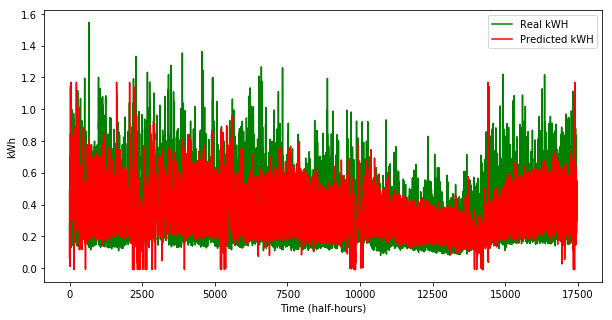

In [21]:
#Plot of the predicted prices versus the real prices
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(agg_ann_1_lvl.y_test.values, color = 'green', label = 'Real kWH')
plt.plot(agg_ann_1_lvl.y_hat.values, color = 'red', label = 'Predicted kWH')
ax.set_ylabel("kWh")
ax.set_xlabel("Time (half-hours)")
ax.legend()

In [22]:
frequency = 800  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)